In [1]:
import numpy as np
from tqdm import tqdm

import argparse
import torch
import torch.nn as nn
import pdb
import os
import pandas as pd
from utils.utils import *
from math import floor
import matplotlib.pyplot as plt
from datasets.dataset_nic import Generic_MIL_Dataset
from datasets.dataset_generic_npy import Generic_WSI_Classification_Dataset, Generic_MIL_Dataset, save_splits
import h5py
from utils.eval_utils import *

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
from sklearn.metrics import auc as calc_auc

In [2]:
data_root_dir = '/home3/gzy/Renal/feature_resnet/'

In [3]:
dataset = Generic_MIL_Dataset(csv_path = 'dataset_csv/renal_subtyping_npy.csv',
                                data_dir = data_root_dir,
                                data_mag = '1_512',
                                shuffle = False, 
                                seed = 10, 
                                print_info = True,
                                label_dict = {'ccrcc':0, 'prcc':1, 'chrcc':2},
                                patient_strat= False,
                                ignore=[])

label column: label
label dictionary: {'ccrcc': 0, 'prcc': 1, 'chrcc': 2}
number of classes: 3
slide-level counts:  
 0    299
1    258
2    103
Name: label, dtype: int64
Patient-LVL; Number of samples registered in class 0: 299
Slide-LVL; Number of samples registered in class 0: 299
Patient-LVL; Number of samples registered in class 1: 258
Slide-LVL; Number of samples registered in class 1: 258
Patient-LVL; Number of samples registered in class 2: 103
Slide-LVL; Number of samples registered in class 2: 103


In [4]:
folds = [0,1,2,3,4]
models_dir = '/home1/gzy/Nature/CLAM/renal_results/renal_subtyping_CLAMMB_res50_1512_5fold_s1'
ckpt_paths = [os.path.join(models_dir, 's_{}_checkpoint.pt'.format(fold)) for fold in folds]
datasets_id = {'train': 0, 'val': 1, 'test': 2, 'all': -1}

In [5]:
ckpt_idx = 0

csv_path = '{}/splits_{}.csv'.format(models_dir, folds[ckpt_idx])
datasets = dataset.return_splits(from_id=False, csv_path=csv_path)
split_dataset = datasets[datasets_id['train']]

In [6]:
def initiate_model(ckpt_path):
    print('Init Model')    
    model_dict = {"dropout": True, 'n_classes': 3, 'fea_dim': 1024}
    model_dict.update({"size_arg": 'small'})
    model = CLAM_MB(**model_dict)

    print_network(model)

    ckpt = torch.load(ckpt_path)
    ckpt_clean = {}
    for key in ckpt.keys():
        if 'instance_loss_fn' in key:
            continue
        ckpt_clean.update({key.replace('.module', ''):ckpt[key]})
    model.load_state_dict(ckpt_clean, strict=False)

    model.relocate()
    model.eval()
    return model

In [7]:
print(ckpt_paths[ckpt_idx])
model = initiate_model(ckpt_paths[ckpt_idx])

print('Init Loaders')
loader = get_simple_loader(split_dataset)

/home1/gzy/Nature/CLAM/renal_results/renal_subtyping_CLAMMB_res50_1512_5fold_s1/s_0_checkpoint.pt
Init Model
CLAM_MB(
  (attention_net): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Attn_Net_Gated(
      (attention_a): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): Tanh()
        (2): Dropout(p=0.25, inplace=False)
      )
      (attention_b): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): Sigmoid()
        (2): Dropout(p=0.25, inplace=False)
      )
      (attention_c): Linear(in_features=256, out_features=3, bias=True)
    )
  )
  (classifiers): ModuleList(
    (0): Linear(in_features=512, out_features=1, bias=True)
    (1): Linear(in_features=512, out_features=1, bias=True)
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
  (instance_classifiers): ModuleList(
    (0): Linear(in_features=5

In [17]:
slide_ids = loader.dataset.slide_data['slide_id']

cls_all = []
cls_3d = [[], [], []]
cls_3d_label = []

det_all = []
p_all = []

logits_h_all = []

inst_label_all = []
    
with torch.no_grad():
    for batch_idx, (data, label, cors, inst_label) in tqdm(enumerate(loader)):
        data, label = data.to(device), label.to(device)
        inst_label = inst_label[0]
        
        slide_id = slide_ids.iloc[batch_idx]
        
        det_logits, det_scores, cls_scores, Y_prob, logits_h = model.check_score(data)
        
        l = label.detach().cpu().numpy()[0]
        cls_3d[l].append(cls_scores)
        
        # p_all += list(Y_prob[0, l].detach().cpu().numpy())
        
        cls_score = cls_scores[:,l].squeeze(-1).detach().cpu().numpy()
        
        if det_scores.shape[0] == 1:
            det_score = det_logits[0,:].squeeze(0).detach().cpu().numpy()
        else:
            det_score = det_logits[l,:].squeeze(0).detach().cpu().numpy()
        
        # det_score = (det_score-det_score.min())/(det_score.max()-det_score.min())
        
        logits_h = (logits_h-logits_h.min())/(logits_h.max()-logits_h.min())
        
        logits_h_all += list(logits_h.detach().cpu().numpy())
        
        if inst_label!=[] and sum(inst_label)!=0:
            cls_all += list(cls_score)
            det_all += list(det_score)
        
        if inst_label!=[] and sum(inst_label)!=0:
            inst_label_all += [1 if patch_label!=0 else 0 for patch_label in inst_label]

527it [00:11, 47.20it/s]


(array([15442., 50973., 66191., 64073., 53876., 40445., 30496., 22353.,
        16978., 12936., 10241.,  8122.,  6573.,  5494.,  4543.,  3895.,
         3409.,  2780.,  2512.,  2142.,  1952.,  1630.,  1512.,  1286.,
         1202.,  1029.,   936.,   856.,   769.,   678.,   602.,   610.,
          523.,   470.,   445.,   413.,   394.,   309.,   297.,   285.,
          255.,   226.,   223.,   165.,   155.,   135.,   147.,   135.,
          101.,   616.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ], dtype=float32),
 <BarContainer object of 50 artists>)

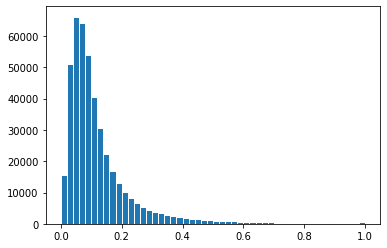

In [18]:
import matplotlib.pyplot as plt

# 绘制直方图
plt.hist(logits_h_all, bins=50, edgecolor='white')

(array([5.0000e+00, 6.0000e+00, 1.7000e+01, 4.3000e+01, 1.3000e+02,
        1.8700e+02, 2.6600e+02, 3.6500e+02, 4.8200e+02, 6.0200e+02,
        7.5200e+02, 9.0100e+02, 1.1310e+03, 1.4640e+03, 1.9440e+03,
        2.7140e+03, 4.0070e+03, 6.1530e+03, 8.8000e+03, 1.2266e+04,
        1.5606e+04, 1.8255e+04, 1.9488e+04, 1.9964e+04, 1.9514e+04,
        1.8059e+04, 1.6296e+04, 1.4160e+04, 1.1719e+04, 9.3360e+03,
        7.2980e+03, 5.6250e+03, 4.2390e+03, 3.2330e+03, 2.6250e+03,
        2.1750e+03, 1.6660e+03, 1.3720e+03, 1.1010e+03, 9.0600e+02,
        8.0600e+02, 6.1000e+02, 4.1600e+02, 2.7400e+02, 1.8200e+02,
        1.0900e+02, 5.6000e+01, 2.7000e+01, 1.0000e+01, 6.0000e+00]),
 array([-28.176355  , -27.43714   , -26.697924  , -25.958708  ,
        -25.219492  , -24.480276  , -23.74106   , -23.001844  ,
        -22.262629  , -21.523413  , -20.784197  , -20.044981  ,
        -19.305765  , -18.56655   , -17.827333  , -17.088118  ,
        -16.348902  , -15.609686  , -14.87047   , -14.131254  

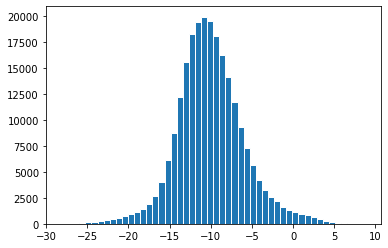

In [16]:
import matplotlib.pyplot as plt

# 绘制直方图
plt.hist(det_all, bins=50, edgecolor='white')

In [36]:
inst_pred_all = [1 if i>0.5 else 0 for i in det_all]

print(roc_auc_score(inst_label_all, det_all))

print(classification_report(inst_label_all, inst_pred_all, zero_division=1))

0.5963465735143787
              precision    recall  f1-score   support

           0       0.49      0.74      0.59    104930
           1       0.66      0.40      0.50    132438

    accuracy                           0.55    237368
   macro avg       0.58      0.57      0.55    237368
weighted avg       0.59      0.55      0.54    237368



In [37]:
df = pd.DataFrame(det_all)

print(df.shape)

print(df[df[0]>0.5].shape)

(237368, 1)
(80916, 1)


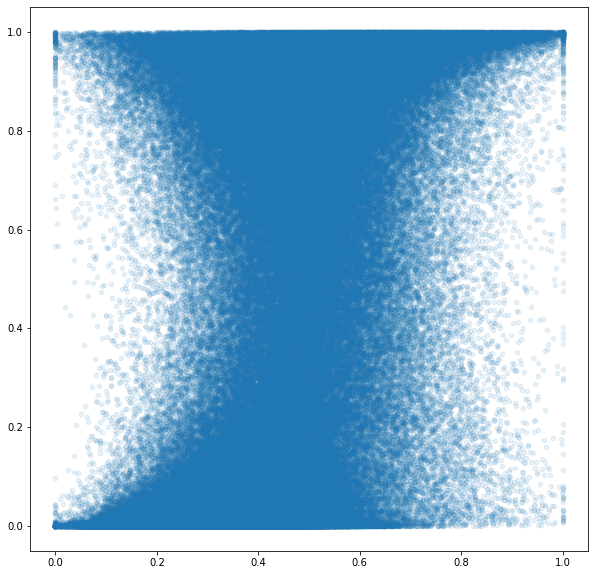

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(det_all, cls_all, s=20, alpha=0.1)

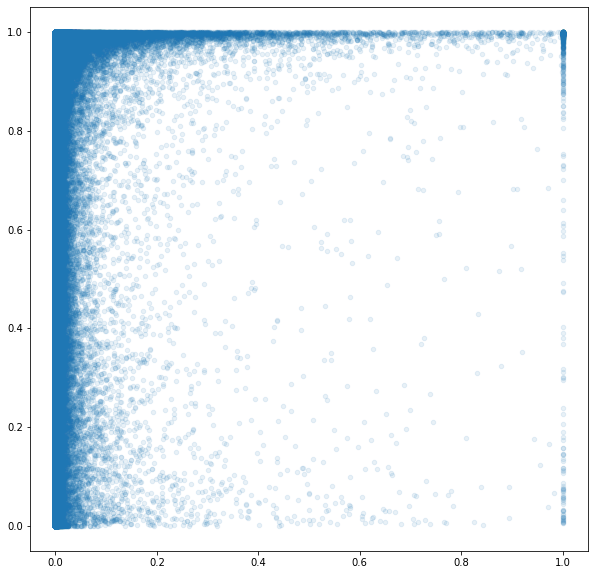

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(det_all, cls_all, s=20, alpha=0.1)

In [61]:
for i in range(len(cls_3d)):
    cls_3d[i] = torch.cat(cls_3d[i], dim=0)
    cls_3d[i] = cls_3d[i].detach().cpu().numpy()

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

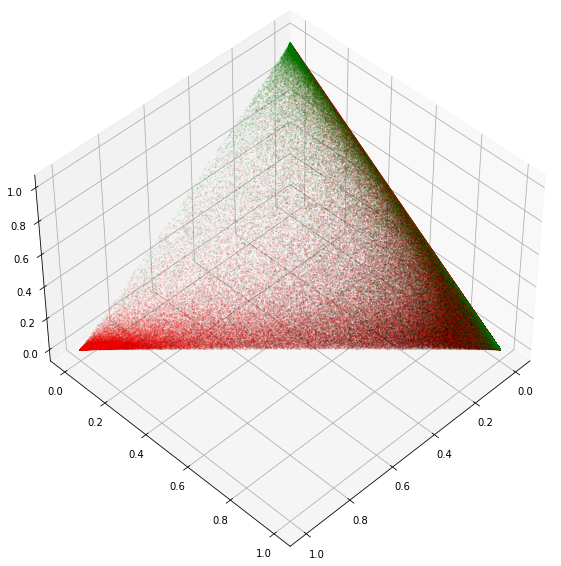

In [91]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
color = ['r','black','g']
for i in range(1000):
    for cls in range(len(cls_3d)):
        segment = int(len(cls_3d[cls])/100)
        ax.scatter(cls_3d[cls][i*segment:(i+1)*segment,0], 
                   cls_3d[cls][i*segment:(i+1)*segment,1], cls_3d[cls][i*segment:(i+1)*segment,2], 
                   c=color[cls], marker='o', s=0.01, alpha=0.5)

ax.view_init(elev=45, azim=45)